# Magnetisation in a Zig-Zag Ising Ladder & ML Phase Classification

**Goal.** Compute field-dependent magnetisation curves for a zig-zag Ising ladder (via a transfer matrix), build a phase diagram, and train an ML model to classify phases from curves.

\begin{equation}
m(B)
\end{equation}

\begin{equation}
4 \times 4
\end{equation}

**Contributions.**
- Transfer-matrix simulation producing curves across coupling ratio and field.
\begin{equation}
\frac{J_3}{J_2}, \quad B
\end{equation}
- Reproducible dataset powering the phase diagram.
\begin{equation}
\texttt{Gridmatrix.csv}
\end{equation}
- ML pipeline (WIP): features from curves to model to metrics.
\begin{equation}
\{\, m,\; \partial m/\partial B \,\} \;\rightarrow\; \text{model} \;\rightarrow\; \text{metrics}
\end{equation}

**TL;DR.** We recover quantised/stepped features indicative of phase boundaries; the classifier learns decision surfaces in parameter–field space.
\begin{equation}
\big(\tfrac{J_3}{J_2},\, B\big)
\end{equation}



## Contents
1. [Background & Model](#background)
2. [Data & Provenance](#data)
3. [Feature Engineering](#features)
4. [Models & Training](#models)
5. [Evaluation & Results](#results)
6. [Ablations & Sensitivity](#ablations)
7. [Error Analysis](#errors)
8. [Reproducibility](#repro)
9. [Limitations & Future Work](#limits)


## Background (compact)

We model a zig-zag Ising ladder with transfer matrices at temperature, couplings, and field:

\begin{equation}
\Theta\;(\mathrm{K}), \qquad J_2,\, J_3\;(\mathrm{K}), \qquad B\;(\mathrm{T})
\end{equation}

Define
\begin{equation}
a = e^{-J_2/(2\Theta)}, \qquad
b = e^{2J_3/\Theta}, \qquad
c = e^{\mu B/(k_B\Theta)}
\end{equation}

with constants \(k_B\) and \(\mu=\mu_B\) where
\begin{equation}
\mu_B = \frac{e h}{4\pi m_e}.
\end{equation}

Let \(\lambda_i\) be the eigenvalues of the \(4\times4\) transfer matrix (ordered by real part):
\begin{equation}
\lambda_1 \ge \lambda_2 \ge \cdots
\end{equation}

For even size \(N\):
\begin{equation}
Z = \lambda_1^{N/2} + \lambda_2^{N/2}, \qquad
f = -\frac{k_B\Theta}{N}\ln Z, \qquad
m(B) = -\frac{1}{\mu}\frac{\partial f}{\partial B}.
\end{equation}

We sweep the coupling ratio
\begin{equation}
x \equiv \frac{J_3}{J_2}
\end{equation}
and evaluate \(m(B)\) on a uniform field grid.

---

## Run Configuration

Temperature:
\begin{equation}
\Theta = 0.1\ \mathrm{K}
\end{equation}

Coupling:
\begin{equation}
J_2 = 4.5\ \mathrm{K}
\end{equation}

Field grid:
\begin{equation}
B \in [0,\,9]\ \mathrm{T}, \qquad \Delta B = 0.1\ \mathrm{T}
\end{equation}

System size:
\begin{equation}
N = 10
\end{equation}

Coupling sweep:
\begin{equation}
J_3 \in [0,\,J_2)\ \text{ in steps of } 0.5\ \mathrm{K}, \qquad x=\frac{J_3}{J_2}
\end{equation}

Outputs (tidy CSV):
\begin{equation}
\texttt{Gridmatrix.csv} :\ (B,\ m,\ J_3/J_2)
\end{equation}

---

## Data & Provenance

File path:
\begin{equation}
\texttt{data/Gridmatrix.csv}
\end{equation}

Column meanings:
\begin{equation}
B\;[\mathrm{T}], \qquad m\;[-], \qquad \frac{J_3}{J_2}\;[-]
\end{equation}

Each row is one field point \(B_i\) at a fixed ratio \(x\). This CSV drives the phase diagram and the ML features.

---

## Visualising the Curves

We plot magnetisation vs field for each ratio as phase fingerprints:
\begin{equation}
m\ \text{vs}\ B \quad \text{grouped by}\ \frac{J_3}{J_2}.
\end{equation}



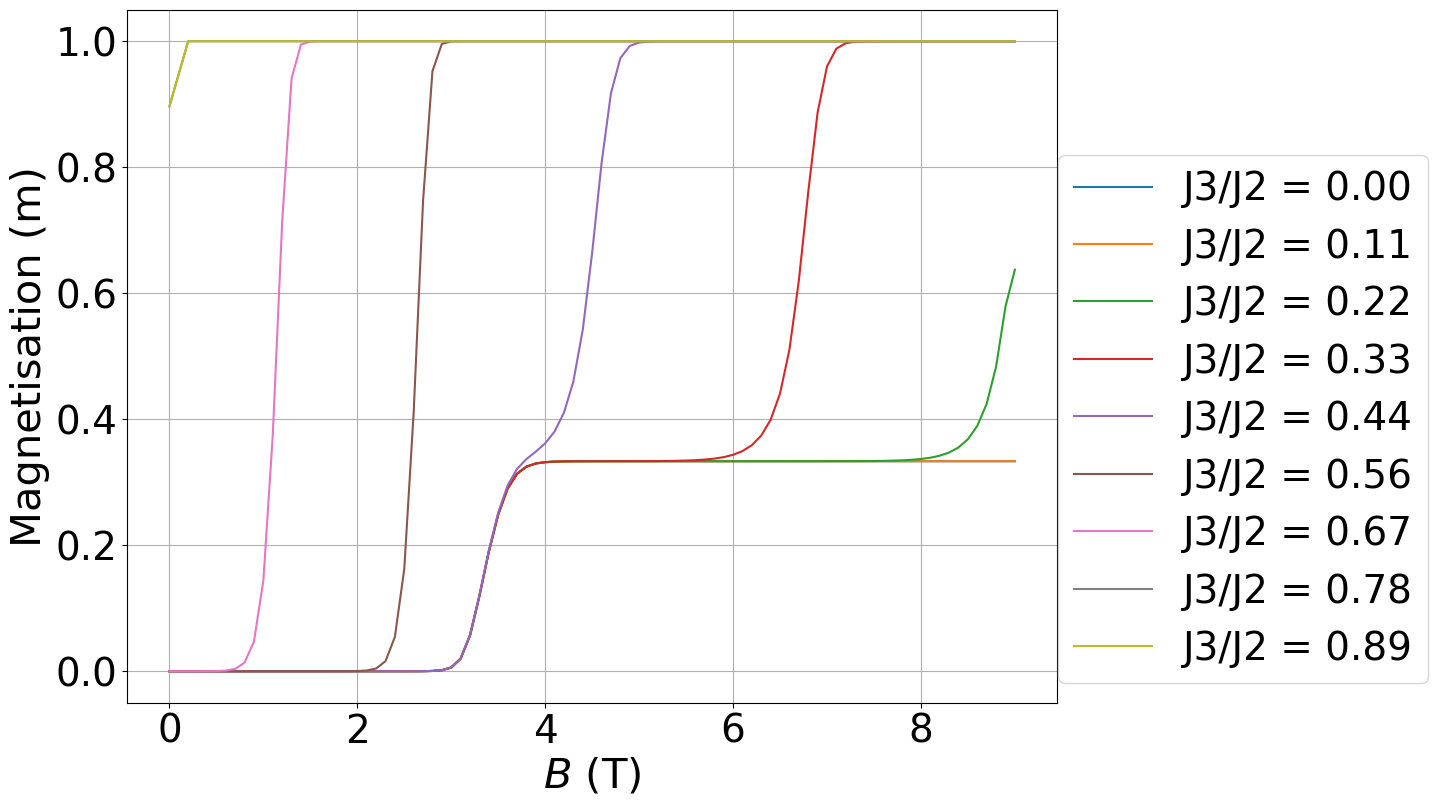

In [73]:
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

# Constants
kb = 1.380649e-23  # J/K
q = 1.602176634e-19  # C
h = 6.62607015e-34  # J s
me = 9.1093837139e-31  # kg
mu = (q * h) / (4 * np.pi * me)  # J/T
eV = 1.602176634e-19  # J

# Parameters
Theta = 0.1  # K
J2 = 4.5  # K
B_values = np.arange(0.0, 9.1, 0.1)  # B from 0 T to 9 T in steps of 0.1 T
N = 10  
#J3Vals =  ([0.5, 1.5, 3])
J3Vals =  np.arange(0.0, J2, 0.5)  # J3 values from 0 to J2 in steps of 0.5


Gridmatrix = []

# Loop over B and J3 values
for J3 in J3Vals:
    a = np.exp(-J2 / (2 * Theta))
    b = np.exp((2 * J3) / Theta)
    Xdata = J3 / J2  

    Z_values = []
    f_values = []

    for B in B_values:
        c = np.exp((mu * B) / (Theta * kb))

        T_matrix = np.array([
            [a**8 * b**2 * c**2, a**5 * b * c, a**3 * c, a**2],
            [a**3 * c, a**4, a**2, (a**5 * b) / c],
            [a**5 * b * c, a**2, a**4, a**3 / c],
            [(a**2),  (a**3) / c, (a**5 * b) / c, (a**8 * b**2) / c**2]
        ])

        eigenvalues = eigvals(T_matrix)
        real_eigenvalues = eigenvalues.real
        sorted_real_eigenvalues = np.sort(real_eigenvalues)[::-1]
        lambda_1, lambda_2 = sorted_real_eigenvalues[:2]

        Z = lambda_1**(N / 2) + lambda_2**(N / 2)
        Z_values.append(Z)

        f = -((kb * Theta) / N) * np.log(Z)
        f_values.append(f)

    f_values = np.array(f_values)
    m_values = -np.gradient(f_values, B_values) / mu

    
    for i, B in enumerate(B_values):
        Gridmatrix.append([B, m_values[i], Xdata])

Gridmatrix = np.array(Gridmatrix)

np.savetxt("Gridmatrix.csv", Gridmatrix, delimiter=",", header="B,m,J3/J2", comments='')
plt.figure(figsize=(12, 9))
for J3 in J3Vals:
    Xdata = J3 / J2
    data = Gridmatrix[np.isclose(Gridmatrix[:, 2], Xdata)]  # Filter data for the current J3/J2
    plt.plot(data[:, 0], data[:, 1], label=f"J3/J2 = {Xdata:.2f}")

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel(r"$B$ (T)", fontsize=30)
plt.ylabel("Magnetisation (m)", fontsize=30)
plt.legend(loc='lower right', bbox_to_anchor=(1.42,0),fontsize = 28)
plt.grid(True)
plt.show()


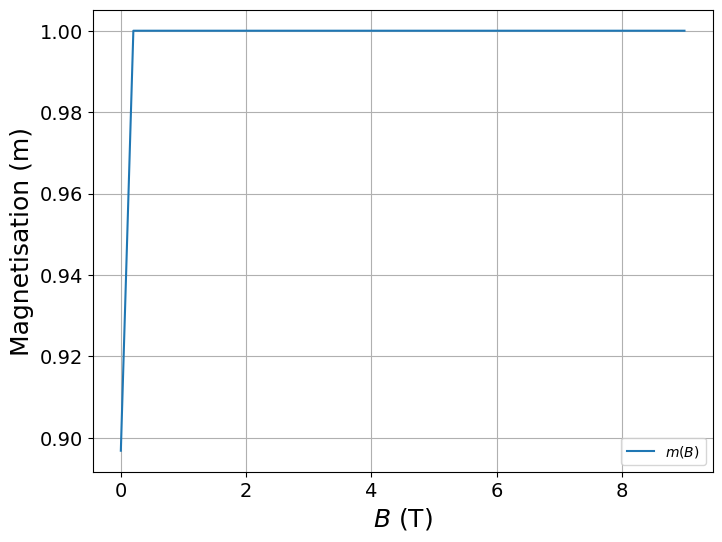

In [81]:
J3_target =  np.array([0.5, 1.5, 3.5])
Xdata = J3_target / J2
#data = Gridmatrix[np.isclose(Gridmatrix[:, 2], Xdata)]

plt.figure(figsize=(8, 6))
plt.plot(data[:, 0], data[:, 1], label=r"$m(B)$")

plt.xlabel(r"$B$ (T)", fontsize = 18)
plt.ylabel(r"Magnetisation (m)",  fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13)
plt.legend()
plt.grid(True)
plt.show()


## Feature Engineering (from curves)

Central differences on a uniform field grid:
\begin{equation}
m'_i \approx \frac{m_{i+1}-m_{i-1}}{B_{i+1}-B_{i-1}}, \qquad
m''_i \approx \frac{m_{i+1}-2m_i+m_{i-1}}{(\Delta B)^2}.
\end{equation}

Plateau criterion (slope threshold \(\tau\)):
\begin{equation}
|m'_i| < \tau \ \Rightarrow\ \text{plateau segment}.
\end{equation}

Kink/step strength:
\begin{equation}
\max_i |m'_i|, \qquad \max_i |m''_i|.
\end{equation}

Global descriptors:
\begin{equation}
\min m,\ \max m,\ \mathrm{mean}(m),\ \mathrm{var}(m).
\end{equation}

Optional spectral features:
\begin{equation}
\text{Top-}k\ \text{DFT magnitudes of}\ m(B).
\end{equation}

---

## Phase Labels

Curvature-based transition candidates with threshold \(\gamma\):
\begin{equation}
\mathcal{C} = \{\, B : |m''(B)| > \gamma \,\}.
\end{equation}

Assign phase regions between consecutive elements of \(\mathcal{C}\). Record chosen thresholds:
\begin{equation}
\tau,\ \gamma.
\end{equation}

To avoid leakage, split/group by ratio:
\begin{equation}
\text{Group by}\ \frac{J_3}{J_2}.
\end{equation}

---

## Models & Training

Model zoo (baseline \(\rightarrow\) advanced):
\begin{equation}
\text{LogReg,\ SVM,\ RandomForest} \quad \text{and} \quad \text{XGBoost/MLP}.
\end{equation}

Classification objective (cross-entropy):
\begin{equation}
\mathcal{L} = - \sum_{i=1}^{n} \sum_{c=1}^{C} y_{ic}\,\log \hat{p}_{ic}.
\end{equation}

Validation protocol:
\begin{equation}
k\text{-fold (e.g., }k=5\text{)},\ \text{stratified},\ \text{report mean}\ \pm\ \text{std}.
\end{equation}

Preprocessing (fit on train only):
\begin{equation}
\text{Standardise continuous features}.
\end{equation}

---

## Evaluation & Metrics

Per-class metrics:
\begin{equation}
\mathrm{Precision}_c=\frac{TP_c}{TP_c+FP_c}, \quad
\mathrm{Recall}_c=\frac{TP_c}{TP_c+FN_c}, \quad
\mathrm{F1}_c=\frac{2\,\mathrm{Precision}_c\,\mathrm{Recall}_c}{\mathrm{Precision}_c+\mathrm{Recall}_c}.
\end{equation}

Macro average:
\begin{equation}
\mathrm{F1}_{\mathrm{macro}}=\frac{1}{C}\sum_{c=1}^{C}\mathrm{F1}_c.
\end{equation}

Also include a confusion matrix and (if applicable) one-vs-rest ROC-AUC.

---

## Results (summary)

Headline metrics:
\begin{equation}
\boxed{\ \text{Macro-F1:}\ \_\_\_\ }\quad
\boxed{\ \text{Accuracy:}\ \_\_\_\ }.
\end{equation}

Typical confusions cluster near critical fields:
\begin{equation}
B_c \in \mathcal{C}.
\end{equation}

Important features often include:
\begin{equation}
\max |m'|,\ \text{plateau count},\ \arg\max |m''|\ \ (\text{approx. } B_c).
\end{equation}


In [1]:
import os
import numpy as np
import csv
import matplotlib.pyplot as plt
import warnings
import pymatgen
from pymatgen.io.cif import CifParser
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.core import Structure
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.io.cif import CifWriter
import networkx as nx
import matminer
from matminer.featurizers.composition import ElementProperty





## Reading Files / Exctracting space group data for report

In [3]:
# Script to filter csv files
def filter_csv(inputData, outputData, columnTitle, targetVal):
    with open(inputData, mode='r', newline='', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        
        with open(outputData, mode='w', newline='', encoding='utf-8') as outfile:
            writer = csv.DictWriter(outfile, fieldnames=reader.fieldnames)
            writer.writeheader()
            
            for row in reader:
                if row[columnTitle] == targetVal:
                    writer.writerow(row)

# File paths for filtering CSV data
infile_path = "C:/Users/willf/Downloads/FilteredCoOxides.csv"
outputData = "C:/Users/willf/Downloads/PythonFilteredCoOxidesTestJ.csv"
Column = "Code" 
Target = '2'  


filter_csv(infile_path, outputData, Column, Target)

# Read and print the filtered CSV content
with open(outputData, newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for index, row in enumerate(reader):
        print(f"Index {index}: {row}")




Index 0: ['Code', 'RefCode', 'Formula', 'Space_Group', 'Composition', 'Disorder', 'R_factor', 'Calculated_Density', 'Cell_Volume', 'Data_Base', 'Comment', 'LIGAND', 'CENTAT', 'SIMPLIG', 'CLUSTER', 'TILE', 'ATOMLIG', 'RING', 'RODPACK', 'SIMPPAR']
Index 1: ['2', '428760', 'Ca2Co2O5', 'P c m b', 'Ca2 Co2 O5', '0', '0.0', '4.27086', '864.78583', 'ICSD', 'Mineral: Brownmillerite. Title: Brownmillerite Ca2Co2O5: synthesis, stability, and re-entrant single crystalto single crystal structural transitions. File: YourCustomFileName_CollCode428760.cif. ', '', '', '', '', '', '', '', '', '']


In [5]:
# Converting a TXT file to CSV
txt_file = "C:/Users/willf/Downloads/MnOxides994/FilteredMnOxides128t_kb.txt"
csv_file = "C:/Users/willf/Downloads/FilteredMnOxides.csv"
df = pd.read_csv(txt_file, delimiter="\t", encoding="ISO-8859-1")
df.to_csv(csv_file, index=False)
print(f"Conversion complete. Saved as {csv_file}")

Conversion complete. Saved as C:/Users/willf/Downloads/FilteredMnOxides.csv


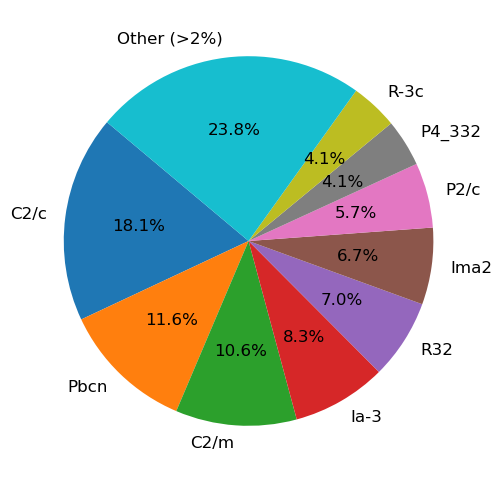

In [7]:
# Load CSV for space group analysis
csv_file = "C:/Users/willf/Downloads/CombinedFilteredSpaceGroupData.csv"
df = pd.read_csv(csv_file)

Column_name = "Space Group Symbol"

# SG calcs
SpaceGroupCounts = df[Column_name].value_counts()
total = SpaceGroupCounts.sum()
filtered_counts = {}
other_count = 0

for group, count in SpaceGroupCounts.items():
    percentage = (count / total) * 100
    if percentage >= 4:  
        filtered_counts[group] = count
    else:
        other_count += count  # Sum up small categories

# 'Other' section 
if other_count > 0:
    filtered_counts["Other (>2%)"] = other_count


labels = list(filtered_counts.keys())
sizes = list(filtered_counts.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140,  textprops={'fontsize': 12})
output_path = "C:/Users/willf/Downloads/FilteredSpaceGroup_PieChart.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

In [13]:
warnings.simplefilter("ignore")
# Define folders containing CIF files
Filt_folders = [
    "C:/Users/willf/Downloads/FilteredCoOxideGPH",
    "C:/Users/willf/Downloads/FilteredNiOxideGPH",
    "C:/Users/willf/Downloads/FilteredMnOxideGPH",
    "C:/Users/willf/Downloads/FilteredFeOxideGPH"
]            

# Dictionary to store space group counts
SGCounts = {}
# Track number of processed files
TotalFiles1 = 0
Err = []
# parse cifs
for Filt_folder in Filt_folders:
    if not os.path.exists(Filt_folder):
        print(f"Warning: Folder not found -> {Filt_folder}")
        continue

    
    with os.scandir(Filt_folder) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.endswith(".cif"):
                try:
                    cif_path = entry.path
                    structure = CifParser(cif_path).get_structures(primitive=False)[0]  
                    SpaceGroupSym, _ = structure.get_space_group_info() # Getting space croup from each cif file 

                    # Update space group counts 
                    SGCounts[SpaceGroupSym] = SGCounts.get(SpaceGroupSym, 0) + 1

                    TotalFiles1 += 1
                    if TotalFiles1 % 500 == 0:
                       print(f"Processed {TotalFiles1} CIF files...")

                except Exception as e:
                    Err.append(f"Error processing {entry.name}: {str(e)}")
if Err:
    with open("cif_errors.log", "w") as log_file:
        log_file.write("\n".join(Err))
    print(f"Finished with {len(Err)} errors. Check cif_errors.log for details.")
TotalSG= sum(SGCounts.values())
Threshold = 0.03 * TotalSG
# Other counts dictionary
Counts = {}
Other_count = 0

for space_group, count in SGCounts.items():
    if count < Threshold:
        Other_count += count  # Adding into 'other'
    else:
        Counts[space_group] = count  

if Other_count > 0:
    Counts["Other"] = Other_count

print(f"Completed processing {TotalFiles1} CIF files.")



Processed 500 CIF files...
Processed 1000 CIF files...
Processed 1500 CIF files...
Processed 2000 CIF files...
Processed 2500 CIF files...
Processed 3000 CIF files...
Processed 3500 CIF files...
Processed 4000 CIF files...
Processed 4500 CIF files...
Processed 5000 CIF files...
Finished with 80 errors. Check cif_errors.log for details.
Completed processing 5024 CIF files.


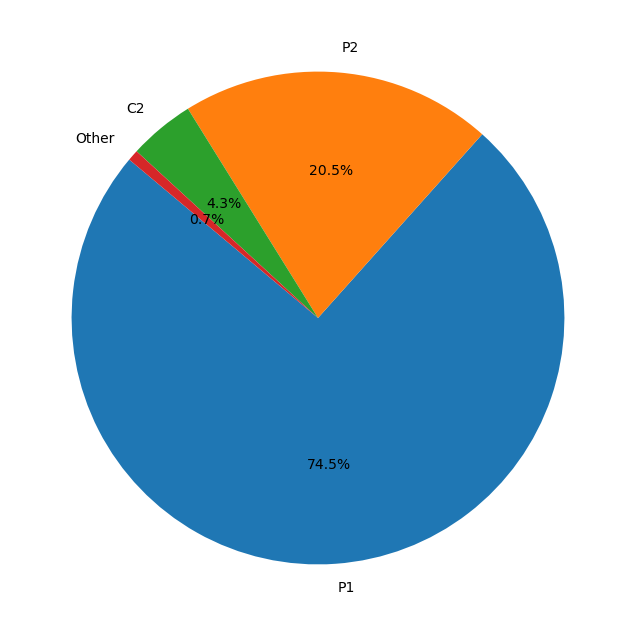

In [15]:
# Plot Pie chart
plt.figure(figsize=(10, 8))
plt.pie(Counts.values(), labels=Counts.keys(), autopct='%1.1f%%', startangle=140)
#plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()
## This pie chart is the space groups that are calculated from topospro

In [17]:
# List of folders containing CIF files
cif_folders = [
   "C:/Users/willf/Downloads/IronOxide999",
   "C:/Users/willf/Downloads/NiOxides453",
    "C:/Users/willf/Downloads/MnOxides994",
    "C:/Users/willf/Downloads/Actual632"
]

data = []

# Loop through each folder
for cif_folder in cif_folders:
    if os.path.exists(cif_folder): 
        for file in os.listdir(cif_folder):  
            if file.endswith(".cif"):
                cif_path = os.path.join(cif_folder, file)  # Full CIF file path

                try:
                    # Parse CIF and extract space group info
                    structure = CifParser(cif_path).get_structures(primitive=False)[0]
                    space_group_number = structure.get_space_group_info()[1]

                    # Assign crystal system based on space group number
                    if 1 <= space_group_number <= 2:
                        crystal_system = "Triclinic"
                    elif 3 <= space_group_number <= 15:
                        crystal_system = "Monoclinic"
                    elif 16 <= space_group_number <= 74:
                        crystal_system = "Orthorhombic"
                    elif 75 <= space_group_number <= 142:
                        crystal_system = "Tetragonal"
                    elif 143 <= space_group_number <= 167:
                        crystal_system = "Trigonal"
                    elif 168 <= space_group_number <= 194:
                        crystal_system = "Hexagonal"
                    elif 195 <= space_group_number <= 230:
                        crystal_system = "Cubic"
                    else:
                        crystal_system = "Unknown"

                except Exception as e:
                    crystal_system = f"Error: {e}"

                # Append results
                data.append([file, space_group_number, crystal_system])


df = pd.DataFrame(data, columns=["Filename", "Space Group Number", "Crystal System"])
output_file = "C:/Users/willf/Downloads/Crystal_Systems_From_CIFs.csv"
df.to_csv(output_file, index=False)
print(f"Crystal systems extracted and saved")


KeyboardInterrupt: 

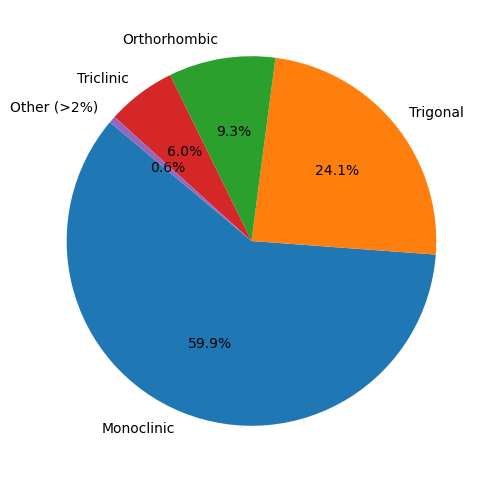

In [70]:
csv1_file = "C:/Users/willf/Downloads/Cleaned_SpaceGroupData.csv"
df = pd.read_csv(csv1_file)
Column_name = "Crystal System"

# SG calcs
CSysCounts = df[Column_name].value_counts()
total = CSysCounts .sum()
filtered_counts = {}
other_count = 0

for group, count in CSysCounts.items():
    percentage = (count / total) * 100
    if percentage >= 4:  
        filtered_counts[group] = count
    else:
        other_count += count  

# 'Other' section 
if other_count > 0:
    filtered_counts["Other (>2%)"] = other_count


labels = list(filtered_counts.keys())
sizes = list(filtered_counts.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
output_path = "C:/Users/willf/Downloads/CrystalSystem_PieChart.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

In [19]:
warnings.simplefilter("ignore")

# Define folders containing CIF files
cif_folders = [
   "C:/Users/willf/Downloads/IronOxide999",
   "C:/Users/willf/Downloads/NiOxides453",
    "C:/Users/willf/Downloads/MnOxides994",
    "C:/Users/willf/Downloads/Actual632"
]

# Dictionary to store space group counts
SpaceGroupCounts = {}
TotalFiles = 0
errors = []

# Process each folder
for cif_folder in cif_folders:
    if not os.path.exists(cif_folder):
        print(f"Warning: Folder not found -> {cif_folder}")
        continue

    
    with os.scandir(cif_folder) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.endswith(".cif"):
                try:
                    cif_path = entry.path
                    structure = CifParser(cif_path).get_structures(primitive=False)[0]  
                    SpaceGroupSym, _ = structure.get_space_group_info() # Getting space croup from each cif file 

                    # Update space group counts 
                    SpaceGroupCounts[SpaceGroupSym] = SpaceGroupCounts.get(SpaceGroupSym, 0) + 1

                    TotalFiles += 1
                    if TotalFiles % 100 == 0:
                        print(f"Processed {TotalFiles} CIF files...")

                except Exception as e:
                    errors.append(f"Error processing {entry.name}: {str(e)}")

# Log errors to a file instead of printing
if errors:
    with open("cif_errors.log", "w") as log_file:
        log_file.write("\n".join(errors))
    print(f"Finished with {len(errors)} errors. Check cif_errors.log for details.")

# Calculate total space group occurrences
Total = sum(SpaceGroupCounts.values())


threshold = 0.03 * Total

# Other counts dictionary
Other_counts = {}
# Set other count to zero so we can add into it 
other_count = 0

for space_group, count in SpaceGroupCounts.items():
    if count < threshold:
        other_count += count  # Adding into 'other'
    else:
        Other_counts[space_group] = count  # Keep main space groups in their own section


if other_count > 0:
    Other_counts["Other"] = other_count

print(f"Completed processing {TotalFiles} CIF files.")



Processed 100 CIF files...
Processed 200 CIF files...
Processed 300 CIF files...
Processed 400 CIF files...
Processed 500 CIF files...
Processed 600 CIF files...
Processed 700 CIF files...
Processed 800 CIF files...
Processed 900 CIF files...
Processed 1000 CIF files...
Processed 1100 CIF files...
Processed 1200 CIF files...
Processed 1300 CIF files...
Processed 1400 CIF files...
Processed 1500 CIF files...
Processed 1600 CIF files...
Processed 1700 CIF files...
Processed 1800 CIF files...
Processed 1900 CIF files...
Processed 2000 CIF files...
Processed 2100 CIF files...
Processed 2200 CIF files...
Processed 2300 CIF files...
Processed 2400 CIF files...
Processed 2500 CIF files...
Finished with 77 errors. Check cif_errors.log for details.
Completed processing 2545 CIF files.


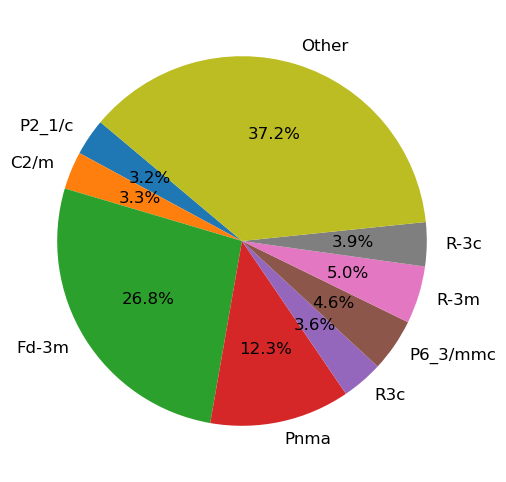

In [21]:
# Plot Pie chart
plt.figure(figsize=(10, 6))
plt.pie(Other_counts.values(), labels=Other_counts.keys(), autopct='%1.1f%%', startangle=140,  textprops={'fontsize': 12})
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()


## Prepping files for ML model

In [23]:
from pymatgen.core import Structure, Lattice, Species, PeriodicSite
folders = [
    "C:/Users/willf/Downloads/FilteredCoOxideGPH",
    "C:/Users/willf/Downloads/FilteredNiOxideGPH",
    "C:/Users/willf/Downloads/FilteredMnOxideGPH",
    "C:/Users/willf/Downloads/FilteredFeOxideGPH"
]            
             

In [27]:
for cif_folder in cif_folders:
    if not os.path.exists(cif_folder):
        print(f"Warning: Folder not found -> {cif_folder}")
        continue

    
    with os.scandir(cif_folder) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.endswith(".cif"):
                try:
                    cif_path = entry.path
                    structure = CifParser(cif_path).get_structures(primitive=False)[0]  
                    StructType, _ = structure

              

SyntaxError: incomplete input (3565409174.py, line 15)

## Duplicate Removal

In [29]:
from pymatgen.core.structure import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher
import shutil

folders = [
    "C:/Users/willf/Downloads/IronOxide999",
    "C:/Users/willf/Downloads/NiOxides453",
    "C:/Users/willf/Downloads/Actual632"
]

matcher = StructureMatcher()
copied = 0
skip = 0

for folder in folders:
    files = [f for f in os.listdir(folder) if f.endswith(".cif")]
    structures = []
    keep = []
    refined_folder = folder + "_refined"
    os.makedirs(refined_folder, exist_ok=True)

    for f in files:
        path = os.path.join(folder, f)
        try:
            structure = CifParser(path).get_structures()[0]
        except:
            skip += 1
            continue

        if not any(matcher.fit(structure, s2) for s2 in structures):
            structures.append(structure)
            keep.append(f)
            shutil.copy2(path, os.path.join(refined_folder, f))
            copied += 1

warnings.simplefilter("ignore", UserWarning)

print(f"Done. {copied}")
print(f"{skip} files skipped due to errors.")


Done. 1126
56 files skipped due to errors.


## Matching frags to full structures using collcode 

In [31]:
import re
import shutil

# files
struct_folder = "C:/Users/willf/Downloads/MnOxides994"
frag_folder = "C:/Users/willf/Downloads/FilteredMnOxideGPH"
output_folder = "C:/Users/willf/Downloads/ZigZagTestFoldMntest"
os.makedirs(output_folder, exist_ok=True)
def get_collcode(filename):
    match = re.search(r"(\d{4,})", filename)
    return match.group(1) if match else None

# dict for file pairs
file_pairs = {}
for fname in os.listdir(struct_folder):
    if fname.endswith(".cif"):
        coll = get_collcode(fname)
        if coll:
            file_pairs[coll] = {"StructCIF": os.path.join(struct_folder, fname), "FragCIFs": []}
# matching by CollCode
for fname in os.listdir(frag_folder):
    if fname.endswith(".cif"):
        coll = get_collcode(fname)
        if coll and coll in file_pairs:
            file_pairs[coll]["FragCIFs"].append(os.path.join(frag_folder, fname))
# sort cifs that have a zigzag
for collcode, paths in file_pairs.items():
    if paths["FragCIFs"]:  # Only copy if there are matched fragments
        src = paths["StructCIF"]
        dst = os.path.join(output_folder, f"{collcode}.cif")
        shutil.copy(src, dst)
        print(f"[COPIED] {collcode} → {dst}")
    else:
        print(f"[SKIPPED] {collcode} has no matching fragments")


[SKIPPED] 100677 has no matching fragments
[SKIPPED] 10144 has no matching fragments
[SKIPPED] 10250 has no matching fragments
[SKIPPED] 10331 has no matching fragments
[SKIPPED] 108995 has no matching fragments
[SKIPPED] 109071 has no matching fragments
[SKIPPED] 109084 has no matching fragments
[SKIPPED] 11273 has no matching fragments
[COPIED] 11274 → C:/Users/willf/Downloads/ZigZagTestFoldMntest\11274.cif
[SKIPPED] 11303 has no matching fragments
[SKIPPED] 120026 has no matching fragments
[SKIPPED] 120027 has no matching fragments
[SKIPPED] 120071 has no matching fragments
[SKIPPED] 120072 has no matching fragments
[SKIPPED] 120073 has no matching fragments
[SKIPPED] 120074 has no matching fragments
[SKIPPED] 120127 has no matching fragments
[SKIPPED] 120131 has no matching fragments
[SKIPPED] 120183 has no matching fragments
[SKIPPED] 120186 has no matching fragments
[COPIED] 120191 → C:/Users/willf/Downloads/ZigZagTestFoldMntest\120191.cif
[SKIPPED] 120197 has no matching fragmen

## Get Feature Vectors

In [39]:
#Cell to make feature vectors
from matminer.featurizers.composition import ElementProperty
#  Root folder
root_folder = "C:/Users/willf/Downloads"

element_folders = {
    "Co": "CoQ",
    "Fe": "NiQ",
    "Ni": "FeQ1",
    "Mn": "MnQ"
}

# magpie featuriser 
mf = ElementProperty.from_preset("magpie")
rows = []
# Loop through all the folders and generate vectors for each structure
for Compound, subfolder in element_folders.items():
    folder_path = os.path.join(root_folder, subfolder)
    for fname in os.listdir(folder_path):
        if fname.endswith(".cif"):
            fpath = os.path.join(folder_path, fname)
            try:
                struct = Structure.from_file(fpath) # build structure from cif 
                composition = struct.composition # find comp of built structure
                features = mf.featurize(composition) # find vectors from each comp
                rows.append([fname, Compound] + features)# convert results into a list
                #print(f"[Yes] {fname} in {Compound}")
            except Exception as e:
                 continue
                #print(f"[No] {fname} in {Compound}: {e}")

# Save vectors
cols = ["filename", "Compound"] + mf.feature_labels()
df = pd.DataFrame(rows, columns=cols)
df.to_csv("QMagpies.csv", index=False)
print(f"DONE")


DONE


## Label data set

In [41]:
import re

df_combined = pd.read_csv("C:/Users/willf/Downloads/MagpieCombinedData.csv")    # Positives + negatives
df_positive = pd.read_csv("C:/Users/willf/Downloads/zigzag_magpie_features2.csv")   # Positives only

def extract_collcode(fname):
    match = re.search(r"(\d{4,})", str(fname))
    return match.group(1) if match else None
    
df_combined["collcode"] = df_combined["filename"].apply(extract_collcode)
df_positive["collcode"] = df_positive["filename"].apply(extract_collcode)
positive_codes = set(df_positive["collcode"].dropna())

#LABELS
#df_combined["label"] = df_combined["collcode"].apply(lambda x: 1 if x in positive_codes else 0)
# df_combined.drop(columns=["collcode"], inplace=True)
#df_combined.to_csv("C:/Users/willf/Downloads/LabelledCombinedData.csv", index=False)
#print(f"LABELS ASSIGNED Positives: {df_combined['label'].sum()}, Total: {len(df_combined)}")


In [43]:
from matminer.featurizers.composition import ElementProperty

Features = ElementProperty.from_preset("magpie")
print(len(Features.feature_labels()))

132


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, f1_score, roc_curve
from sklearn.metrics import matthews_corrcoef, classification_report

## ML MODEL


Classification Report (Threshold = 0.53):

              precision    recall  f1-score   support

 Non-Zig-Zag       0.90      0.93      0.92        30
     Zig-Zag       0.86      0.80      0.83        15

    accuracy                           0.89        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.89      0.89      0.89        45



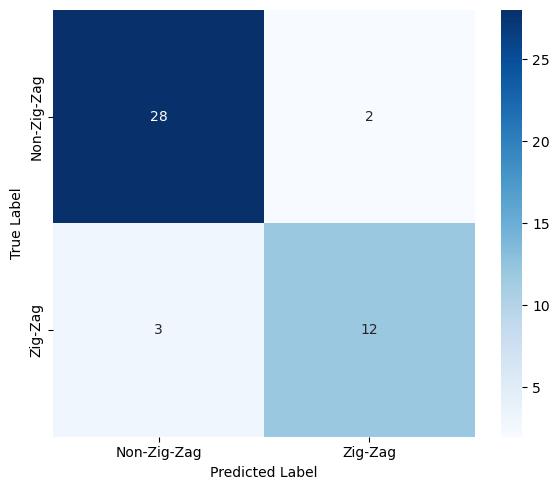

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1516
           1       0.36      0.98      0.53       149

    accuracy                           0.84      1665
   macro avg       0.68      0.91      0.72      1665
weighted avg       0.94      0.84      0.87      1665

Subsetset MCC: 0.7467286566323438


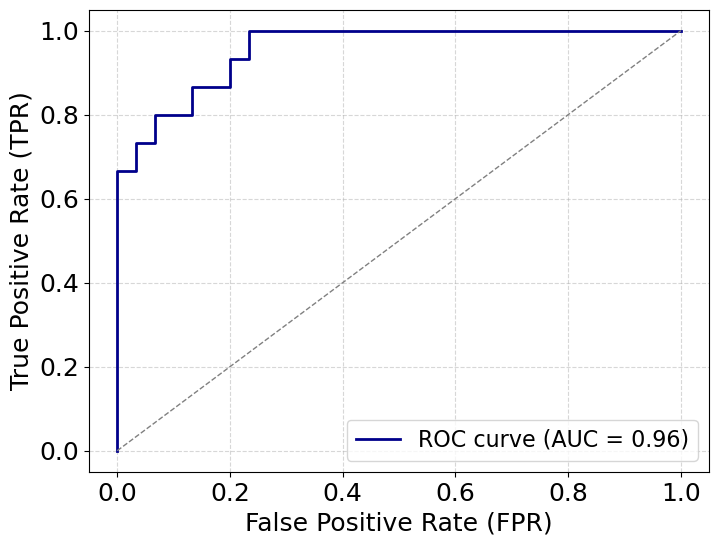

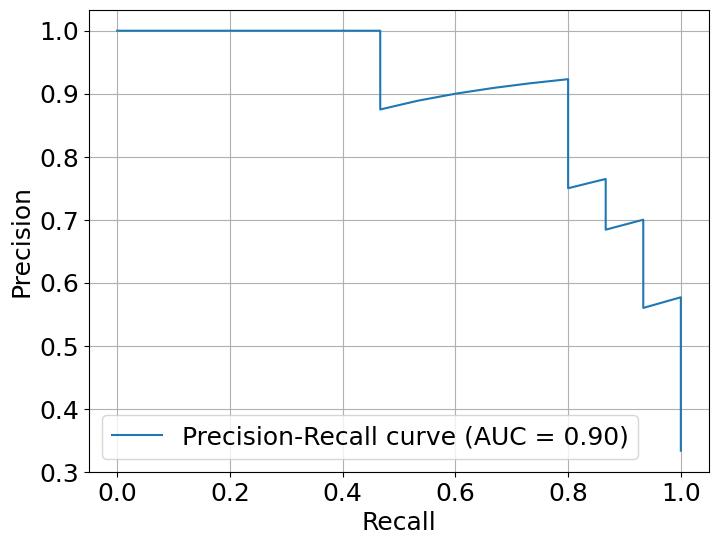

Optimal Threshold: 0.53
Optimal F1-score: 0.86


In [47]:
df = pd.read_csv("C:/Users/willf/Downloads/Balanced_ZigZag_2to1.csv")
# Drop irrelevant columns
X = df.drop(columns=["filename", "label", "Compound", "collcode"], errors="ignore")
y = df["label"]  # 1 = zig-zag, 0 = non-zig-zag

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split: 90% temp, 10% test 
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.10, stratify=y, random_state=42
)

# Split temp into train (90%) and val (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, stratify=y_temp, random_state=42
)

#Retrain
X_trainval = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True)
y_trainval = pd.concat([y_train, y_val], ignore_index=True)

# Fit Random Forest
model_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 10}, 
    random_state=42
)
model_final.fit(X_trainval, y_trainval)

# Custom threshold to tell the model what probability to classify a zigzag
probs = model_final.predict_proba(X_test)[:, 1]  # Zigzag class probabilities
threshold = 0.53 # Custom threshold
custom_preds = (probs > threshold).astype(int)

# Report and confusion matrix
print(f"\nClassification Report (Threshold = {threshold}):\n")
print(classification_report(y_test, custom_preds, target_names=["Non-Zig-Zag", "Zig-Zag"]))

cm = confusion_matrix(y_test, custom_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Zig-Zag", "Zig-Zag"],
            yticklabels=["Non-Zig-Zag", "Zig-Zag"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

df_full = pd.read_csv("C:/Users/willf/Downloads/LabelledCombinedData.csv")

# Drop columns and scale features 
X_full = df_full.drop(columns=["filename", "label", "Compound", "collcode"], errors="ignore")
y_full = df_full["label"]
X_full_scaled = scaler.transform(X_full)  # Use same scaler as training

probs_full = model_final.predict_proba(X_full_scaled)[:, 1]
custom_preds_full = (probs_full > 0.5).astype(int)

#MCC
from sklearn.metrics import classification_report, matthews_corrcoef
print(classification_report(y_full, custom_preds_full))
print("Subsetset MCC:", matthews_corrcoef(y_test, custom_preds))

fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)  
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=16) 
plt.grid(True, linestyle='--', alpha=0.5)  
plt.show()


# Train the Random Forest Classifier 
model_final = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight={0: 1, 1: 10}, random_state=42)
model_final.fit(X_train, y_train)

# Get the predicted probabilities for the positive class
y_scores = model_final.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate F1-score at each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find best Threshold from F-1 scores
optimal_threshold_index = f1_scores.argmax()
optimal_threshold = thresholds[optimal_threshold_index]
optimal_f1_score = f1_scores[optimal_threshold_index]

# Plot Precision-Recall curve and F1-score
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

# Display the optimal threshold and F1-score
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Optimal F1-score: {optimal_f1_score:.2f}")


In [49]:
# Separate zig-zag (label = 1) and non-zig-zag (label = 0)
df = pd.read_csv("C:/Users/willf/Downloads/LabelledCombinedData.csv")
zigzag_df = df[df["label"] == 1]
non_zigzag_df = df[df["label"] == 0]

ratio = 3 # ratio of non-zig-zags to zig zags
n_zigzag = len(zigzag_df)
n_non_zigzag = ratio * n_zigzag

# Downsample non-zig-zags to match desired ratio
non_zigzag_downsampled = non_zigzag_df.sample(n=n_non_zigzag, random_state=42)

balanced_df = pd.concat([zigzag_df, non_zigzag_downsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df.to_csv("C:/Users/willf/Downloads/Balanced_ZigZag_3to1.csv", index=False)
print(f"Saved balanced dataset with {len(zigzag_df)} zig-zags and {n_non_zigzag} non-zig-zags.")

Saved balanced dataset with 149 zig-zags and 447 non-zig-zags.


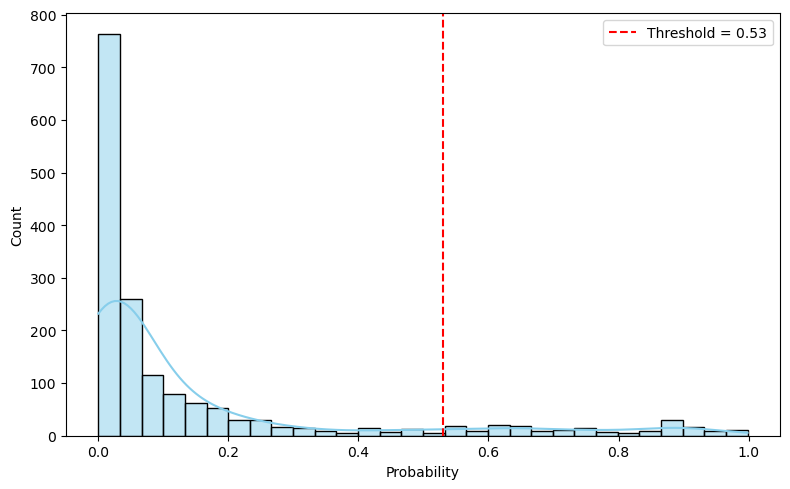

              precision    recall  f1-score   support

 Non-Zig-Zag       0.90      0.93      0.92        30
     Zig-Zag       0.86      0.80      0.83        15

    accuracy                           0.89        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.89      0.89      0.89        45

Matthews Correlation Coefficient (MCC): 0.747


In [51]:
df = pd.read_csv("C:/Users/willf/Downloads/LabelledCombinedData.csv")

# Drop label and pointless columns
X_full = df.drop(columns=["filename", "label", "Compound", "collcode"], errors="ignore")
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
y_trainval = df["label"]
model_final.fit(X_full_scaled, y_trainval) 
probs = model_final.predict_proba(X_full_scaled)[:, 1]
threshold = 0.53
preds = (probs > threshold).astype(int)

# save results with probabilities
results = df.copy()
results["Predicted_Label"] = preds
results["ZigZag_Probability"] = probs

# Sort from highest prob to lowest
zigzag_candidates = results[results["Predicted_Label"] == 1].sort_values(by="ZigZag_Probability", ascending=False)
zigzag_candidates.to_csv("C:/Users/willf/Downloads/Top_ZigZag_Predictions.csv", index=False)

results.to_csv("C:/Users/willf/Downloads/All_ZigZag_Predictions.csv", index=False)
plt.figure(figsize=(8, 5))
sns.histplot(probs, bins=30, color = 'skyblue',  kde=True)
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("ZigZag_Probability_Distribution.png", dpi=300)
plt.show()


print(classification_report(y_test, custom_preds, target_names=["Non-Zig-Zag", "Zig-Zag"]))

# MCC - a score to show how good the model is, spans from -1 to 1 where 1 is the best
mcc = matthews_corrcoef(y_test, custom_preds)
print("Matthews Correlation Coefficient (MCC):", round(mcc, 3))


## Using the same model to give probabilities and produce a table 

In [53]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib


features_path = "C:/Users/willf/Downloads/QMagpies.csv"
X_quaternary = pd.read_csv(features_path)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 10}, 
    random_state=42
)
X_trainval = pd.DataFrame(X_temp).reset_index(drop=True)
y_trainval = pd.Series(y_temp).reset_index(drop=True)

model_final.fit(X_trainval, y_trainval)


id_column = 'CollCode' if 'CollCode' in X_quaternary.columns else None

non_feature_cols = ["CollCode", "filename", "Compound"]
columns_to_use = X_quaternary.columns.difference(non_feature_cols, sort=False)
X_features = X_quaternary[columns_to_use]

# Predict probabilities for the zig-zag class
probs = model_final.predict_proba(X_features)[:, 1]

# Attach probability coloumn
X_quaternary["ZigZag_Probability"] = probs

# Sort by predicted probability
ranked = X_quaternary.sort_values(by="ZigZag_Probability", ascending=False)
top_20 = ranked.head(20)
top_20_path = "C:/Users/willf/Downloads/QuarternaryPred2.csv"
top_20.to_csv(top_20_path, index=False)
print(top_20[["filename", "Compound", "ZigZag_Probability"]].to_string(index=False))


               filename Compound  ZigZag_Probability
 CoQ_CollCode153184.cif       Co            0.316286
 CoQ_CollCode153186.cif       Co            0.316286
FeQ1_CollCode118314.cif       Ni            0.153067
 NiQ_CollCode207989.cif       Fe            0.151562
 NiQ_CollCode250467.cif       Fe            0.151562
 NiQ_CollCode427988.cif       Fe            0.151562
  NiQ_CollCode66835.cif       Fe            0.151250
  NiQ_CollCode79947.cif       Fe            0.150408
 MnQ_CollCode252572.cif       Mn            0.150134
  NiQ_CollCode66836.cif       Fe            0.147404
 NiQ_CollCode201055.cif       Fe            0.147404
 CoQ_CollCode281706.cif       Co            0.146987
  NiQ_CollCode78361.cif       Fe            0.146562
 NiQ_CollCode410817.cif       Fe            0.146562
  CoQ_CollCode28218.cif       Co            0.145833
  CoQ_CollCode24979.cif       Co            0.145833
  NiQ_CollCode79948.cif       Fe            0.145408
 NiQ_CollCode417788.cif       Fe            0.

In [59]:
import pandas as pd

# Load predictions
df = pd.read_csv("C:/Users/willf/Downloads/QuarternaryPred2.csv")  # Replace with your path if different

threshold = 0.53
top_n = 128

top = df[df["ZigZag_Probability"] > threshold].copy()
top = df["ZigZag_Probability"].copy()
top = df.sort_values("ZigZag_Probability", ascending=False).head(top_n)
top["ICSD CollCode"] = top["filename"].str.extract(r"CollCode(\d+)", expand=False)


top["Compound"] = top["filename"].str.extract(r"^(.*?)_CollCode", expand=False)

# create columns and order
top = top[["Compound", "ICSD CollCode", "ZigZag_Probability"]]
top = top.rename(columns={"ZigZag_Probability": "Probability"})
top["Probability"] = top["Probability"].round(3)
top.to_csv("C:/Users/willf/Downloads/Quarternarytest2.csv", index=False)
print(top.to_markdown(index=False))



| Compound   |   ICSD CollCode |   Probability |
|:-----------|----------------:|--------------:|
| CoQ        |          153184 |         0.316 |
| CoQ        |          153186 |         0.316 |
| FeQ1       |          118314 |         0.153 |
| NiQ        |          207989 |         0.152 |
| NiQ        |          250467 |         0.152 |
| NiQ        |          427988 |         0.152 |
| NiQ        |           66835 |         0.151 |
| NiQ        |           79947 |         0.15  |
| MnQ        |          252572 |         0.15  |
| NiQ        |          201055 |         0.147 |
| NiQ        |           66836 |         0.147 |
| CoQ        |          281706 |         0.147 |
| NiQ        |           78361 |         0.147 |
| NiQ        |          410817 |         0.147 |
| CoQ        |           28218 |         0.146 |
| CoQ        |           24979 |         0.146 |
| NiQ        |           79948 |         0.145 |
| NiQ        |          417788 |         0.145 |
| NiQ        |      

## Removing doped ternaries and making a report friendly table 

In [64]:
import os
import pandas as pd
import re
from pymatgen.io.cif import CifParser
from pymatgen.core import Composition


#top_preds = pd.read_csv("C:/Users/willf/Downloads/Top_ZigZag_Candidates_Fixed2.csv")
top_preds = pd.read_csv("C:/Users/willf/Downloads/Quarternarytest2.csv")
# Drop duplicate CollCodes 
top_preds = top_preds.drop_duplicates(subset="ICSD CollCode", keep="first")
top_collcodes = top_preds["ICSD CollCode"].astype(str).tolist()

#cif_folders = [
 #   "C:/Users/willf/Downloads/IronOxide999",
 #   "C:/Users/willf/Downloads/NiOxides453",
 #   "C:/Users/willf/Downloads/MnOxides994",
 #   "C:/Users/willf/Downloads/Actual632"
#]

cif_folders = [
    
    "C:/Users/willf/Downloads/CoQ",
     "C:/Users/willf/Downloads/MnQ",
     "C:/Users/willf/Downloads/FeQ1",
    "C:/Users/willf/Downloads/NiQ"

]

# Fuction to round non-integer compositions 
def round_composition(composition):
    comp_dict = composition.get_el_amt_dict()
    rounded_dict = {el: round(amount) for el, amount in comp_dict.items()}
    return Composition(rounded_dict)

#Function to get rid of doped ternaries (For Quarternary Data)
def is_doped_ternary(composition):
    comp_dict = composition.get_el_amt_dict()
    if len(comp_dict) != 4:
        return False  # not a quaternary
    values = list(comp_dict.values())
    return any(x < 0.2 for x in values) and any(x > 0.5 for x in values)

# Scan csv to get the 'irrelevant columns'
records = []

for folder in cif_folders:
    for file in os.listdir(folder):
        if file.endswith(".cif"):
            match = re.search(r"CollCode(\d{4,6})", file)
            if match:
                collcode = match.group(1)
                if collcode in top_collcodes:
                    cif_path = os.path.join(folder, file)
                    try:
                        parser = CifParser(cif_path)
                        structure = parser.get_structures()[0]
                        composition = structure.composition
                        
                        # Skip if no elements 
                        if not composition or len(composition.elements) < 3:
                            continue
                        
                        
                        if is_doped_ternary(composition):
                            continue
                        
                        # round decimal formulas
                        rounded_composition = round_composition(composition)
                        formula = rounded_composition.alphabetical_formula
                        
                        spacegroup = structure.get_space_group_info()[0]
                        
                    except Exception as e:
                        print(f"Failed to parse {cif_path}: {e}")
                        continue  


                    # Get model predictions for each compound
                    prob = top_preds[top_preds["ICSD CollCode"] == int(collcode)]["Probability"].values[0]

                    records.append({
                        "Compound": formula,
                        "ICSD CollCode": collcode,
                        "Space Group": spacegroup,
                        "Probability": round(prob, 3)
                    })
                    
df = pd.DataFrame(records)
df = df.drop_duplicates(subset="Compound", keep="first")   
df = df.sort_values(by="Probability", ascending=False)
df.to_csv("C:/Users/willf/Downloads/FinalQPreds3.csv", index=False)
print(df.to_markdown(index=False))
print(df[df["ICSD CollCode"] == 153184])

| Compound         |   ICSD CollCode | Space Group   |   Probability |
|:-----------------|----------------:|:--------------|--------------:|
| Al3 Cs40 Fe1 O20 |          118314 | Pnnm          |         0.153 |
| N28 Ni8 O84 Rb12 |          207989 | Pnma          |         0.152 |
| K4 N8 Ni2 O24    |          250467 | Cc            |         0.152 |
| N6 Ni1 O4        |           66835 | C2/m          |         0.151 |
| Mn3 O24 P6 V4    |          252572 | P-1           |         0.15  |
| B20 Nd4 Ni4 O40  |           79947 | P2_1/c        |         0.15  |
| B24 Co4 Na4 O42  |          281706 | C2/c          |         0.147 |
| H12 N6 Ni1 O4    |          201055 | C2/m          |         0.147 |
| Cs4 N8 Ni2 O24   |          410817 | P-1           |         0.147 |
| K6 N10 Ni2 O20   |           78361 | P2_1/m        |         0.147 |
| B20 Co4 O40 Sm4  |           24979 | P2_1/c        |         0.146 |
| B20 Co4 Nd4 O40  |           28218 | P2_1/c        |         0.146 |
| Ni2 

## Sensitivity 

Feature removal:
\begin{equation}
\Delta \mathrm{F1}\ \text{ after dropping spectral features}.
\end{equation}

Resolution change:
\begin{equation}
\Delta B = 0.2\ \mathrm{T}\ \Rightarrow\ \Delta \mathrm{F1} = \boxed{\ \_\_\_\ }.
\end{equation}

Noise robustness:
\begin{equation}
m \leftarrow m + \mathcal{N}(0,\sigma^2), \quad \sigma=\boxed{\ \_\_\_\ }.
\end{equation}

Thermodynamic vs finite size:
\begin{equation}
f_{\infty}\ \approx\ -\frac{k_B\Theta}{N}\ln\!\big(\lambda_{\max}^{N/2}\big)\ \text{ vs current finite-}N.
\end{equation}

---

## Error Analysis

Inspect misclassified curves near
\begin{equation}
\mathcal{C} = \{ B : |m''(B)| > \gamma \}.
\end{equation}

Compare true vs predicted classes and annotate peaks of:
\begin{equation}
|m'|\ \text{ and }\ |m''|.
\end{equation}

---

## Reproducibility

Environment:
\begin{equation}
\text{Python,\ NumPy,\ SciPy,\ Matplotlib,\ scikit-learn}
\end{equation}

Seeds:
\begin{equation}
\text{Deterministic seeds for splits and training}.
\end{equation}

Data provenance:
\begin{equation}
\texttt{data/Gridmatrix.csv}\ \text{generated by this notebook/code}.
\end{equation}

---

## Limitations & Future Work

Finite-size effects:
\begin{equation}
N=10 \quad \text{vs} \quad N\rightarrow\infty\ (\lambda_{\max}).
\end{equation}

Labelling assumptions:
\begin{equation}
\text{Heuristic thresholds } (\tau,\ \gamma)\ \text{to validate or replace}.
\end{equation}

Grid expansion:
\begin{equation}
\big(\tfrac{J_3}{J_2},\, \Theta\big)\ \text{refinement for a fuller phase diagram}.
\end{equation}

Uncertainty estimates:
\begin{equation}
\text{Ensembling or MC dropout for probabilistic predictions}.
\end{equation}

---

